# TRANSDUCTIVE SUPPORT VECTOR MACHINE

Dans ce notebook nous implementerons les classe SVM et TSVM et verrons laquelle est la plus efficace dans le cadre de l'apprentissage semi-supervise

L'ensemble de données que nous utiliserons contient les informations sur les utilisateurs qui sont des clients
potentiels d'un produit ou d'un service. 
Il contient quatre caractéristiques d'entrée : 
-User ID : identifiant unique attribué à chaque utilisateur
-Age : Age de l'utilisateur en années
-Gender : genre de l'utilisateur, qui peut être "Male" ou "Female"
-EstimatedSalary : Estimation du salaire annuel de l'utilisateur

Ces dernieres sont utilisées pour prédire si l'utilisateur a acheté ou non le produit, comme l'indique la colonne
de sortie ou de cible "Purchased".



In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap



# CHARGEMENT ET EXPLORATION DES DONNEES

In [87]:
path = 'User_Data.csv'


df = pd.read_csv(path)

df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [88]:
df.describe()

,User ID,Age,EstimatedSalary,Purchased
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


In [89]:
# Appliquer le one-hot encoding à la colonne 'Gender'
df = pd.get_dummies(df, columns=['Gender'], dtype=int)
df.head()


,User ID,Age,EstimatedSalary,Purchased,Gender_Female,Gender_Male
0,15624510,19,19000,0,0,1
1,15810944,35,20000,0,0,1
2,15668575,26,43000,0,1,0
3,15603246,27,57000,0,1,0
4,15804002,19,76000,0,0,1


                  User ID  Gender_Male  Gender_Female       Age  Purchased   
User ID          1.000000    -0.025249       0.025249 -0.000721   0.007120  \
Gender_Male     -0.025249     1.000000      -1.000000 -0.073741  -0.042469   
Gender_Female    0.025249    -1.000000       1.000000  0.073741   0.042469   
Age             -0.000721    -0.073741       0.073741  1.000000   0.622454   
Purchased        0.007120    -0.042469       0.042469  0.622454   1.000000   
EstimatedSalary  0.071097    -0.060435       0.060435  0.155238   0.362083   

                 EstimatedSalary  
User ID                 0.071097  
Gender_Male            -0.060435  
Gender_Female           0.060435  
Age                     0.155238  
Purchased               0.362083  
EstimatedSalary         1.000000  


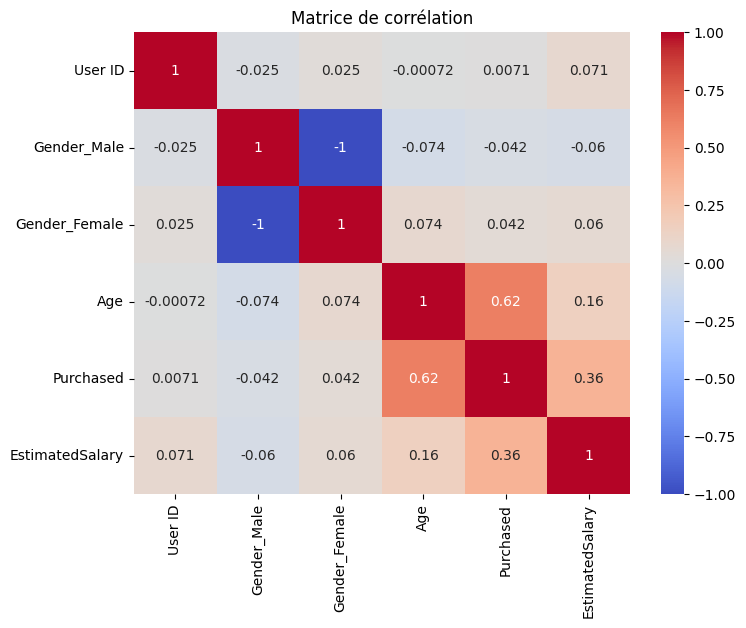

In [90]:
# Calculer la matrice de corrélation
corr_matrix = df[['User ID', 'Gender_Male','Gender_Female', 'Age', 'Purchased', "EstimatedSalary"]].corr()

print(corr_matrix)

# Afficher la matrice de corrélation avec une heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()


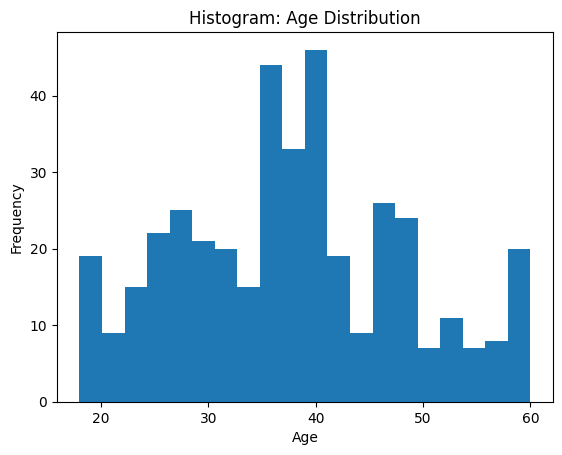

In [91]:
plt.hist(df['Age'], bins=20)  # Vous pouvez ajuster le nombre de bacs (bins) selon vos préférences.
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram: Age Distribution')
plt.show()


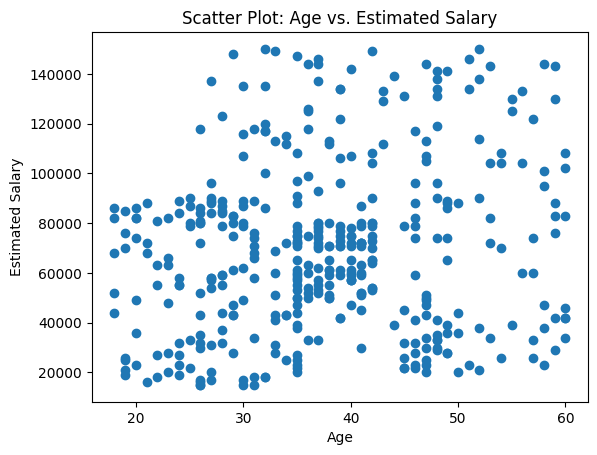

In [92]:
plt.scatter(df['Age'], df['EstimatedSalary'])
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.title('Scatter Plot: Age vs. Estimated Salary')
plt.show()

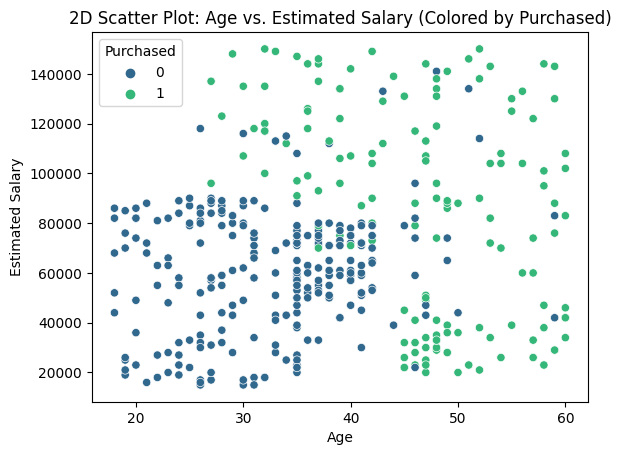

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

# Suppose que vos données sont stockées dans un DataFrame appelé 'df'.
sns.scatterplot(x='Age', y='EstimatedSalary', hue='Purchased', data=df, palette='viridis')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.title('2D Scatter Plot: Age vs. Estimated Salary (Colored by Purchased)')
plt.show()


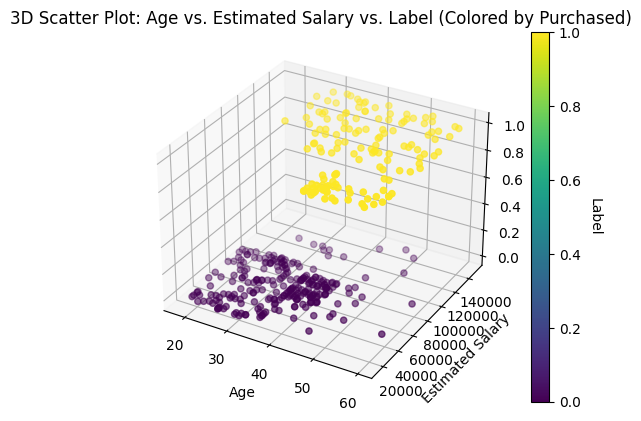

In [94]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Créer une figure en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Tracer les points en 3D et colorer en fonction des Purchased
scatter = ax.scatter(df['Age'], df['EstimatedSalary'], df['Purchased'], c=df['Purchased'], cmap='viridis')

# Étiqueter les axes
ax.set_xlabel('Age')
ax.set_ylabel('Estimated Salary')
ax.set_zlabel('Purchased')

# Ajouter une barre de couleur pour la représentation des labels
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Label', rotation=270, labelpad=15)

# Afficher le graphe en 3D
plt.title('3D Scatter Plot: Age vs. Estimated Salary vs. Label (Colored by Purchased)')
plt.show()


In [95]:
# Changer l'ordre des colonnes
df = df[['Age', 'EstimatedSalary', 'Gender_Female', 'Gender_Male', 'Purchased']]

df.head()


,Age,EstimatedSalary,Gender_Female,Gender_Male,Purchased
0,19,19000,0,1,0
1,35,20000,0,1,0
2,26,43000,1,0,0
3,27,57000,1,0,0
4,19,76000,0,1,0


# Divison du dataset

In [96]:
# Classe pour la mise à échelle des features
class MyStandardScaler:
    
    def __init__(self):
        self.mean_ = None
        self.scale_ = None
        
    def fit(self, X):
        self.mean_ = X.mean()
        self.scale_ = X.std()
        
    def transform(self, X):
        X = (X - self.mean_) / self.scale_
        return X.values
        
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


In [97]:
def split_data(df, train_percent):
    """
        Fonction pour le decoupage du jeu de données
        en données d'entrainement et de teste
    """
    
    scaler = MyStandardScaler()
    np.random.seed(2)
    perm = np.random.permutation(df.index)

    n= len(df)
    train_index = int(train_percent * n)
    

    train = df.iloc[perm[:train_index]]
    test = df.iloc[perm[train_index:]]

    #x_train, x_test, y_train, y_test = train.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7]], test.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7 ]], np.array(train.loc[:, 'Outcome']).reshape(-1, 1), np.array(test.loc[:, 'Outcome']).reshape(-1, 1) 
    x_train, x_test, y_train, y_test = train.iloc[:, :-1], test.iloc[:, :-1], np.array(train.loc[:, 'Purchased']).reshape(-1, 1), np.array(test.loc[:, 'Purchased']).reshape(-1, 1)
    scaler.fit(x_train)
    scaler.fit(x_test)
    #[2, 3, 4, 5]

    x_train_norm = scaler.fit_transform(x_train)
    x_test_norm = scaler.fit_transform(x_test)

    return x_train_norm, x_test_norm, y_train, y_test

In [98]:
X_lab, X_unl, y_lab, y_unl = split_data(df, train_percent=0.4)

X_lab.shape, X_unl.shape, y_lab.shape, y_unl.shape


((160, 4), (240, 4), (160, 1), (240, 1))

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, train_size=0.7)
#X_train, X_test, y_train, y_test = split_data(X, train_percent=0.75)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((112, 4), (48, 4), (112, 1), (48, 1))

In [100]:
print("X_lab shape:", X_lab.shape)
print("X_unl shape:", X_unl.shape)
print("y_lab shape:", y_lab.shape)
print("y_unl shape:", y_unl.shape)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
#print("X_train : ", X_train.shape)
#print("y_train : ", y_train.shape)


X_lab shape: (160, 4)
X_unl shape: (240, 4)
y_lab shape: (160, 1)
y_unl shape: (240, 1)
X_train shape: (112, 4)
y_train shape: (112, 1)


In [101]:
print(y_train[:10])


[[1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]]


In [102]:
print(y_test[:10])

[[0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [103]:
print(X_test[:10])

[[-1.32914944 -0.28112518 -0.93639641  0.93639641]
 [ 1.08968484  0.61905616 -0.93639641  0.93639641]
 [ 1.96046518  0.96751346  1.06124926 -1.06124926]
 [-1.13564269 -0.7166968   1.06124926 -1.06124926]
 [ 0.41241124  2.36134264 -0.93639641  0.93639641]
 [-1.23239607  0.64809427 -0.93639641  0.93639641]
 [ 0.99293147  2.12903777 -0.93639641  0.93639641]
 [ 0.2189045   0.12540833  1.06124926 -1.06124926]
 [-1.13564269 -1.03611599 -0.93639641  0.93639641]
 [ 0.2189045   0.21252265 -0.93639641  0.93639641]]


# Implementation de la class SVM

In [104]:
class support_vector_machine():
    # Initialisation de l'objet avec les données d'entraînement, la constante de pénalisation et une graine aléatoire
    def __init__(self, X, C, seed=123):
        self.x_t = X
        m, n = X.shape
        np.random.seed(seed)
        # Initialisation des paramètres de theta
        self.theta = np.random.rand(n+1, 1)
        self.C = C
    
    # Prédiction de la classe de chaque exemple donné en entrée
    def predict(self, X):
        m, n = X.shape
        # Ajout d'une colonne de 1 pour permettre la multiplication matricielle avec theta
        X_1 = np.hstack((np.ones((m, 1)), X))
        # Calcul de la prédiction en comparant la sortie de la multiplication avec un seuil de 0
        return np.dot(X_1, self.theta)>0
    
    # Fonction de perte de charnière (hinge loss)
    def hinge_loss(self, y, y_hat):
        m, _ = y.shape

        # Transformation de la sortie attendue en {-1, 1} pour simplifier les calculs
        y_1 = np.copy(y)
        y_1[y_1==0] = -1

        # Calcul de la norme de theta et de la somme maximale de la fonction de perte de charnière
        norm_theta = np.power(np.linalg.norm(self.theta), 2)
        max_sum = np.sum(np.where((1 - np.multiply(y_1, y_hat)) > 0, 1, 0) * (self.C * (1 - y_1 * y_hat))/ m)

        # Calcul de la fonction de perte finale
        return 1/2 * norm_theta + max_sum
    
    def fit(self, x, y, learning_rate=0.001, num_iters=200):
        # On récupère les dimensions de x
        m, n = x.shape
        
        # On remplace les 0 de y par -1
        y_1 = np.copy(y)
        y_1[y_1==0] = -1
        
        # On ajoute une colonne de 1 à x pour le biais
        x_1 = np.hstack((np.ones((m, 1)), x))
        
        # On initialise le tableau pour stocker les valeurs de la fonction de coût
        J_history = np.zeros(num_iters)

        # Boucle d'entrainement sur un certain nombre d'itérations
        for i in range(0, num_iters):
            # On met à jour les poids ou paramètres
            #self.theta = self.theta - learning_rate * (self.theta - np.sum(np.where((1 - np.multiply(y_1, np.dot(x_1, self.theta))) > 0, 1, 0) * (self.C/m)*y_1*x_1,axis=0).reshape(-1, 1))
            self.theta = self.theta - learning_rate * (self.theta - np.sum(np.where((1 - np.multiply(y_1, np.dot(x_1, self.theta))) > 0, 1, 0) * (self.C/m)*y_1*x_1, axis=0).reshape(-1, 1)) - learning_rate * self.C * self.theta


            # On calcule la fonction de coût pour cette itération et on la stocke
            J_history[i] = self.hinge_loss(y_1, np.dot(x_1, self.theta))
            #print(f"\nEpoch {i}, loss {J_history[i]}")
        
        # On renvoie le tableau des valeurs de la fonction de coût
        return J_history

    def accuracy(self,y_test, y_pred):
        # On calcule l'accuracy en pourcentage
        accuracy = 100 * np.sum(y_test == y_pred) / len(y_test)
        return accuracy


<h3> Recherche des meilleurs parametres </h3>

In [ ]:
# Liste des valeurs à explorer pour le taux d'apprentissage, C et le nombre d'itérations
learning_rates = [0.1 ,0.001,0.0001, 0.00001]
C_values = [1 ,2, 3, 5, 10, 50, 100, 200, 300, 500, 600, 800, 1000, 1200, 1500, 1700]
#num_iters_list = [5000, 6000,7000, 8000,10000]
num_iters_list = [50, 80, 100, 200, 300, 400 ,500, 1000, 5000, 7000, 10000]

best_accuracy = 0.0
best_learning_rate = 0.0
best_C = 0
best_num_iters = 0

# Boucle pour explorer différentes combinaisons de valeurs d'hyperparamètres
for learning_rate in learning_rates:
    for C in C_values:
        for num_iters in num_iters_list:
            model = support_vector_machine(X_train, C=C)
            history = model.fit(X_train, y_train, learning_rate=learning_rate, num_iters=num_iters)
            y_pred = model.predict(X_test)
            accuracy = model.accuracy(y_test, y_pred)
            print(f"\nLearning Rate: {learning_rate}, C: {C}, Num Iters: {num_iters}, Accuracy: {accuracy}")

            # Vérifier si cette combinaison donne une meilleure précision
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_learning_rate = learning_rate
                best_C = C
                best_num_iters = num_iters

print("\nBest Parameters:")
print("Best Learning Rate:", best_learning_rate)
print("Best C:", best_C)
print("Best Num Iters:", best_num_iters)
print("Best Accuracy:", best_accuracy)


In [106]:

model = support_vector_machine(X_train, 3)
history = model.fit(X_train, y_train, learning_rate=0.001, num_iters=500)


# Obtenir les prédictions de votre modèle SVM pour les données de test
y_pred = model.predict(X_train)

print("Model accuracy on train dataset : ", model.accuracy(y_pred, y_train))


Model accuracy on train dataset :  81.25


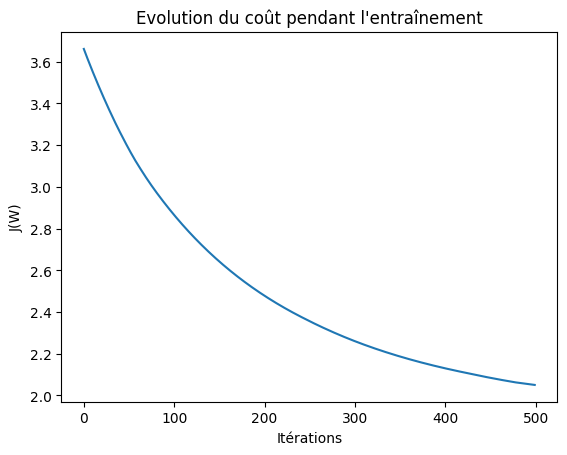

In [107]:
plt.plot(history)
plt.xlabel("Itérations")
plt.ylabel("J(W)")
plt.title("Evolution du coût pendant l\'entraînement")
plt.show()

In [108]:
y_pred2= model.predict(X_test)

print("Model accuracy on test dataset : ", model.accuracy(y_pred2, y_test))


Model accuracy on test dataset :  81.25


# Implementation de la classe TSVM

In [109]:


class TransductiveSVM:
    def __init__(self, C=1.0, Cu=1.0, learning_rate=0.01, n_iterations=1000, batch_size=5):
        self.C = C  # Paramètre de régularisation pour les données étiquetées
        self.Cu = Cu  # Paramètre de régularisation pour les données non étiquetées
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.w = None #poids
        self.b = None #biais
        
        
        self.b_labeled = None
        self.w_labeled = None

    def fit(self, X_labeled, y_labeled, X_unlabeled):
        # Création d'un objet SVM pour l'apprentissage supervisé sur les données étiquetées
        svm = support_vector_machine(X_labeled, C=self.C)
        svm.fit(X_labeled, y_labeled , learning_rate=self.learning_rate, num_iters=self.n_iterations)
        #svm.fit(X_labeled, y_labeled)

        # List to store the costs at each iteration
        costs = []
        
        # Récupération des poids et du biais appris par le SVM sur les données étiquetées
        self.w = svm.theta[1:] #Weigths
        self.b = svm.theta[0] # Biais
    
        # Concaténation des données étiquetées et non étiquetées pour une utilisation conjointe
        X_all = np.concatenate((X_labeled, X_unlabeled), axis=0)

        # Calcul des marges pour les données non étiquetées
        margins_unlabeled = X_unlabeled.dot(self.w) + self.b

        
        # Étiquetage des données non étiquetées en fonction des marges calculées
        y_unlabeled = np.sign(margins_unlabeled) #Retourne -1 ou 1

        
        
        # Concaténation des étiquettes des données étiquetées et non étiquetées
        y_all = np.concatenate((y_labeled, y_unlabeled), axis=0)

        
        n_samples = len(y_all)

        
        # Ajout des variables d'écart pour les données non étiquetées
        slack_variables = np.zeros(n_samples)

        #Optimisation par descente de gradient en mini-batches
        for _ in range(self.n_iterations):
            # Mélanger aléatoirement les exemples à chaque itération
            indices = np.random.permutation(n_samples)
            X_all_shuffled = X_all[indices]
            y_all_shuffled = y_all[indices]

            for i in range(0, n_samples, self.batch_size):
                # Sélectionner le mini-batch courant
                X_batch = X_all_shuffled[i:i + self.batch_size]
                y_batch = y_all_shuffled[i:i + self.batch_size]

                # Calcul de la marge pour chaque exemple du mini-lot
                margins = y_batch * (X_batch.dot(self.w) + self.b)
                
               
                
                # Calcul des variables d'écart pour les exemples du mini-lot
                slack_variables[i:i + self.batch_size] = np.maximum(0, 1 - margins).flatten()  # 0 et 1
 
                
                # Calcul du Cout
                cost = np.mean(slack_variables[i:i + self.batch_size])  # Use mean instead of sum for cost calculation
                costs.append(cost)  # Store the cost in the list
                
                # Mise à jour des poids et du biais pour les exemples du mini-lot
                for j in range(len(X_batch)):
                    if slack_variables[i + j] > 0:
                        if i + j < len(y_labeled):
                            # Pour les données étiquetées
                            gradient_w = self.w - self.C * y_batch[j] * X_batch[j].reshape(-1, 1)  # Redimensionnement pour une cohérence de dimensions
                            gradient_b = -self.C * y_batch[j]
                        else:
                            # Pour les données non étiquetées
                            gradient_w = self.w - self.Cu * y_batch[j] * X_batch[j].reshape(-1, 1)  # Redimensionnement pour une cohérence de dimensions
                            gradient_b = 0

                        # Mise à jour des poids et du biais par descente de gradient pour l'exemple du mini-lot
                        self.w -= self.learning_rate * gradient_w
                        self.b -= self.learning_rate * gradient_b

        # Une fois l'optimisation terminée, nous ne conservons que les poids pour les données étiquetées
        self.w_labeled = self.w
        self.b_labeled = self.b
        
        return costs


    def predict(self, X_test):
        # Prédiction sur les données de test
        margins = X_test.dot(self.w_labeled) + self.b_labeled
        predictions = np.sign(margins) #1 ou -1
        return np.round((predictions + 1) / 2).astype(int) # 0 ou 1

    
    
    def accuracy(self,y_test, y_pred):
        # On calcule l'accuracy en pourcentage
        accuracy = 100 * np.sum(y_test == y_pred) / len(y_test)
        return accuracy
        


<h3> Recherche des meilleurs parametres </h3>

In [35]:
# Liste des valeurs à explorer pour le taux d'apprentissage, C et le nombre d'itérations
learning_rates = [0.1, 0.01]
C_values = [0.1 ,1 , 3, 5, 10, 100]
Cu_values = [0.2, 0.5, 1, 3, 5]
#num_iters_list = [5000, 6000,7000, 8000,10000]
num_iters_list = [50, 100, 300, 500, 1000]
batch_sizes = [5 ,10, 20]

best_accuracy = 0.0
best_learning_rate = 0.0
best_C = 0
best_num_iters = 0
best_Cu = 0
best_batch = 0

# Boucle pour explorer différentes combinaisons de valeurs d'hyperparamètres
for learning_rate in learning_rates:
    for C in C_values:
        for num_iters in num_iters_list:
            for Cu in Cu_values:
                for batch in batch_sizes:
                    t_svm_model = TransductiveSVM(C=C, Cu=Cu, learning_rate=learning_rate, n_iterations=num_iters, batch_size=batch)
                    t_svm_model.fit(X_lab, y_lab, X_unl)
                    y_pred = model.predict(X_test)
                    accuracy = model.accuracy(y_test, y_pred)
                    print(f"\nLearning Rate: {learning_rate}, C: {C}, Cu: {Cu}, Num Iters: {num_iters} , Accuracy: {accuracy}")

                    # Vérifier si cette combinaison donne une meilleure précision
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_learning_rate = learning_rate
                        best_C = C
                        best_num_iters = num_iters
                        best_Cu = Cu
                        
print("\nBest Parameters:")
print("Best Learning Rate:", best_learning_rate)
print("Best C:", best_C)
print("Best Num Iters:", best_num_iters)
print("Best Cu:", best_Cu)
print("Best Batch:", best_batch)
print("Best Accuracy:", best_accuracy)



Learning Rate: 0.1, C: 0.1, Cu: 0.2, Num Iters: 50 , Accuracy: 81.25

Learning Rate: 0.1, C: 0.1, Cu: 0.2, Num Iters: 50 , Accuracy: 81.25

Learning Rate: 0.1, C: 0.1, Cu: 0.2, Num Iters: 50 , Accuracy: 81.25

Learning Rate: 0.1, C: 0.1, Cu: 0.5, Num Iters: 50 , Accuracy: 81.25

Learning Rate: 0.1, C: 0.1, Cu: 0.5, Num Iters: 50 , Accuracy: 81.25

Learning Rate: 0.1, C: 0.1, Cu: 0.5, Num Iters: 50 , Accuracy: 81.25

Learning Rate: 0.1, C: 0.1, Cu: 1, Num Iters: 50 , Accuracy: 81.25

Learning Rate: 0.1, C: 0.1, Cu: 1, Num Iters: 50 , Accuracy: 81.25

Learning Rate: 0.1, C: 0.1, Cu: 1, Num Iters: 50 , Accuracy: 81.25

Learning Rate: 0.1, C: 0.1, Cu: 3, Num Iters: 50 , Accuracy: 81.25

Learning Rate: 0.1, C: 0.1, Cu: 3, Num Iters: 50 , Accuracy: 81.25

Learning Rate: 0.1, C: 0.1, Cu: 3, Num Iters: 50 , Accuracy: 81.25

Learning Rate: 0.1, C: 0.1, Cu: 5, Num Iters: 50 , Accuracy: 81.25

Learning Rate: 0.1, C: 0.1, Cu: 5, Num Iters: 50 , Accuracy: 81.25

Learning Rate: 0.1, C: 0.1, Cu: 5, 


Learning Rate: 0.1, C: 1, Cu: 5, Num Iters: 300 , Accuracy: 81.25

Learning Rate: 0.1, C: 1, Cu: 0.2, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 1, Cu: 0.2, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 1, Cu: 0.2, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 1, Cu: 0.5, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 1, Cu: 0.5, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 1, Cu: 0.5, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 1, Cu: 1, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 1, Cu: 1, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 1, Cu: 1, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 1, Cu: 3, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 1, Cu: 3, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 1, Cu: 3, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 1, Cu: 5, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 1, Cu: 5, Num Iters: 500 ,


Learning Rate: 0.1, C: 5, Cu: 0.2, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.1, C: 5, Cu: 0.2, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.1, C: 5, Cu: 0.2, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.1, C: 5, Cu: 0.5, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.1, C: 5, Cu: 0.5, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.1, C: 5, Cu: 0.5, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.1, C: 5, Cu: 1, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.1, C: 5, Cu: 1, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.1, C: 5, Cu: 1, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.1, C: 5, Cu: 3, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.1, C: 5, Cu: 3, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.1, C: 5, Cu: 3, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.1, C: 5, Cu: 5, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.1, C: 5, Cu: 5, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.1, C: 5, Cu: 5, Num Iters: 100 ,


Learning Rate: 0.1, C: 10, Cu: 0.2, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.1, C: 10, Cu: 0.2, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.1, C: 10, Cu: 0.2, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.1, C: 10, Cu: 0.5, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.1, C: 10, Cu: 0.5, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.1, C: 10, Cu: 0.5, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.1, C: 10, Cu: 1, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.1, C: 10, Cu: 1, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.1, C: 10, Cu: 1, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.1, C: 10, Cu: 3, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.1, C: 10, Cu: 3, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.1, C: 10, Cu: 3, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.1, C: 10, Cu: 5, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.1, C: 10, Cu: 5, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.1, C

/tmp/ipykernel_174085/1962243990.py:29: RuntimeWarning: overflow encountered in multiply
  max_sum = np.sum(np.where((1 - np.multiply(y_1, y_hat)) > 0, 1, 0) * (self.C * (1 - y_1 * y_hat))/ m)
/tmp/ipykernel_174085/1962243990.py:29: RuntimeWarning: invalid value encountered in multiply
  max_sum = np.sum(np.where((1 - np.multiply(y_1, y_hat)) > 0, 1, 0) * (self.C * (1 - y_1 * y_hat))/ m)
/tmp/ipykernel_174085/1962243990.py:52: RuntimeWarning: overflow encountered in multiply
  self.theta = self.theta - learning_rate * (self.theta - np.sum(np.where((1 - np.multiply(y_1, np.dot(x_1, self.theta))) > 0, 1, 0) * (self.C/m)*y_1*x_1, axis=0).reshape(-1, 1)) - learning_rate * self.C * self.theta
/tmp/ipykernel_174085/1962243990.py:52: RuntimeWarning: invalid value encountered in subtract
  self.theta = self.theta - learning_rate * (self.theta - np.sum(np.where((1 - np.multiply(y_1, np.dot(x_1, self.theta))) > 0, 1, 0) * (self.C/m)*y_1*x_1, axis=0).reshape(-1, 1)) - learning_rate * self.C * sel


Learning Rate: 0.1, C: 100, Cu: 0.2, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 100, Cu: 0.2, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 100, Cu: 0.2, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 100, Cu: 0.5, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 100, Cu: 0.5, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 100, Cu: 0.5, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 100, Cu: 1, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 100, Cu: 1, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 100, Cu: 1, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 100, Cu: 3, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 100, Cu: 3, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 100, Cu: 3, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 100, Cu: 5, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C: 100, Cu: 5, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.1, C


Learning Rate: 0.01, C: 1, Cu: 5, Num Iters: 50 , Accuracy: 81.25

Learning Rate: 0.01, C: 1, Cu: 5, Num Iters: 50 , Accuracy: 81.25

Learning Rate: 0.01, C: 1, Cu: 5, Num Iters: 50 , Accuracy: 81.25

Learning Rate: 0.01, C: 1, Cu: 0.2, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.01, C: 1, Cu: 0.2, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.01, C: 1, Cu: 0.2, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.01, C: 1, Cu: 0.5, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.01, C: 1, Cu: 0.5, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.01, C: 1, Cu: 0.5, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.01, C: 1, Cu: 1, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.01, C: 1, Cu: 1, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.01, C: 1, Cu: 1, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.01, C: 1, Cu: 3, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.01, C: 1, Cu: 3, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.01, C: 1, Cu: 3, Num 


Learning Rate: 0.01, C: 3, Cu: 5, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.01, C: 3, Cu: 5, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.01, C: 3, Cu: 5, Num Iters: 500 , Accuracy: 81.25

Learning Rate: 0.01, C: 3, Cu: 0.2, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.01, C: 3, Cu: 0.2, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.01, C: 3, Cu: 0.2, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.01, C: 3, Cu: 0.5, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.01, C: 3, Cu: 0.5, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.01, C: 3, Cu: 0.5, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.01, C: 3, Cu: 1, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.01, C: 3, Cu: 1, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.01, C: 3, Cu: 1, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.01, C: 3, Cu: 3, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.01, C: 3, Cu: 3, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.01, C: 


Learning Rate: 0.01, C: 10, Cu: 3, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.01, C: 10, Cu: 5, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.01, C: 10, Cu: 5, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.01, C: 10, Cu: 5, Num Iters: 100 , Accuracy: 81.25

Learning Rate: 0.01, C: 10, Cu: 0.2, Num Iters: 300 , Accuracy: 81.25

Learning Rate: 0.01, C: 10, Cu: 0.2, Num Iters: 300 , Accuracy: 81.25

Learning Rate: 0.01, C: 10, Cu: 0.2, Num Iters: 300 , Accuracy: 81.25

Learning Rate: 0.01, C: 10, Cu: 0.5, Num Iters: 300 , Accuracy: 81.25

Learning Rate: 0.01, C: 10, Cu: 0.5, Num Iters: 300 , Accuracy: 81.25

Learning Rate: 0.01, C: 10, Cu: 0.5, Num Iters: 300 , Accuracy: 81.25

Learning Rate: 0.01, C: 10, Cu: 1, Num Iters: 300 , Accuracy: 81.25

Learning Rate: 0.01, C: 10, Cu: 1, Num Iters: 300 , Accuracy: 81.25

Learning Rate: 0.01, C: 10, Cu: 1, Num Iters: 300 , Accuracy: 81.25

Learning Rate: 0.01, C: 10, Cu: 3, Num Iters: 300 , Accuracy: 81.25

Learning Rate: 0.01, 


Learning Rate: 0.01, C: 100, Cu: 1, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.01, C: 100, Cu: 3, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.01, C: 100, Cu: 3, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.01, C: 100, Cu: 3, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.01, C: 100, Cu: 5, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.01, C: 100, Cu: 5, Num Iters: 1000 , Accuracy: 81.25

Learning Rate: 0.01, C: 100, Cu: 5, Num Iters: 1000 , Accuracy: 81.25

Best Parameters:
Best Learning Rate: 0.1
Best C: 0.1
Best Num Iters: 50
Best Cu: 0.2
Best Batch: 0
Best Accuracy: 81.25


In [110]:
#Instanciation de la classe
t_svm = TransductiveSVM(C=3, Cu=0.5, learning_rate=0.001, n_iterations=500, batch_size=5)

# Entraînement du modèle
costs_history = t_svm.fit(X_lab, y_lab, X_unl)


# Evaluation du modele T-SVM sur les donnees d'entrainement

In [111]:
y_pred_test = t_svm.predict(X_test)

print("T-SVM model accuracy on test dataset : ", t_svm.accuracy(y_test, y_pred_test))


T-SVM model accuracy on test dataset :  85.41666666666667


<h3> Visualisation des points de test avec l'hyperplan de test <h3>

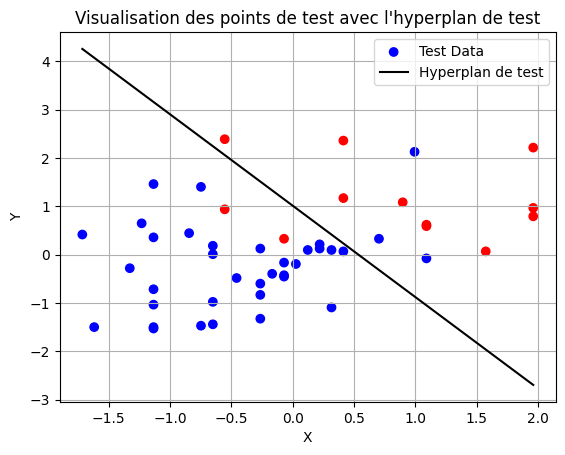

In [112]:

plt.title("Visualisation des points de test avec l'hyperplan de test")

cmap = ListedColormap(['blue', 'red'])  # Utilisez 'blue' et 'red' pour représenter les classes 0 et 1

# Tracer les points de test avec les couleurs correspondant à chaque classe
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap, label='Test Data')

# Tracer l'hyperplan de test
w = t_svm.w
b = t_svm.b
a = -w[0] / w[1]
xx = np.linspace(min(X_test[:, 0]), max(X_test[:, 0]), 100)
yy = a * xx - (b) / w[1]
plt.plot(xx, yy, 'k-', label='Hyperplan de test')

# Légendes et affichage
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()


# Utilisation  de la methode de classique

In [113]:
# Entraîner le SVM sur les données étiquetées
model_supervised = support_vector_machine(X_train, 3)  # Assurez-vous de spécifier le bon nombre de classes ici
history_supervised = model_supervised.fit(X_train, y_train, learning_rate=0.001, num_iters=500)

# Prédire les étiquettes des données non étiquetées à l'aide du modèle supervisé
y_pred_unlabeled = model_supervised.predict(X_unl)

# Combiner les prédictions avec les données étiquetées pour former un nouvel ensemble d'apprentissage
X_combined = np.vstack((X_train, X_unl))
y_combined = np.concatenate((y_train, y_pred_unlabeled))


<h3> Reentrainement du model sur les nouvelles donnees </h3>

In [114]:
# Entraîner le SVM à nouveau sur le nouvel ensemble d'apprentissage combiné
model_combined = support_vector_machine(X_combined, 3)  # Assurez-vous de spécifier le bon nombre de classes ici
history_combined = model_combined.fit(X_combined, y_combined, learning_rate=0.001, num_iters=500)


# Obtenir les prédictions du modèle combiné pour les données de test
y_pred_test = model_combined.predict(X_test)

# Évaluer les performances du modèle combiné
accuracy_test = model_combined.accuracy(y_test, y_pred_test)
print("Model accuracy on test dataset:", accuracy_test)


Model accuracy on test dataset: 70.83333333333333


<h3> Visualisation des points de test avec l'hyperplan de test <h3>

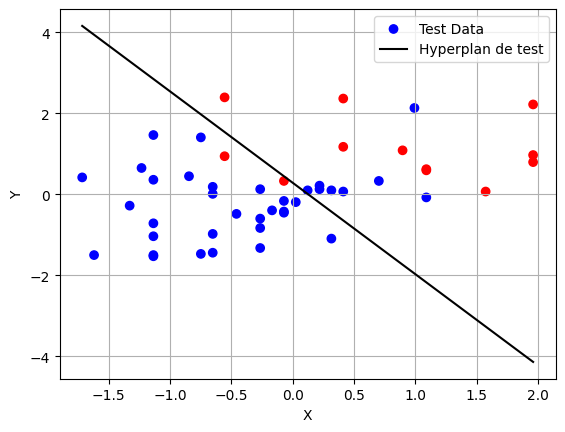

In [115]:
# ...
cmap = ListedColormap(['blue', 'red'])  # Utilisez 'blue' et 'red' pour représenter les classes 0 et 1

# Tracer les points de test avec les couleurs correspondant à chaque classe
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap, label='Test Data')

# Tracer l'hyperplan de test
w = model_combined.theta[1:]
b = model_combined.theta[0]
a = -w[0] / w[1]
xx = np.linspace(min(X_test[:, 0]), max(X_test[:, 0]), 100)
yy = a * xx - (b) / w[1]
plt.plot(xx, yy, 'k-', label='Hyperplan de test')

# Légendes et affichage
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()


On observe que le modele T-SVM predit mieux sur les donnees d'entrainement.

In [116]:

#Les poids et le biais du modele SVM Classique
print("Parametres pour le SVM classique sur les donnees labelisees")
print("Les poids : ", model_supervised.theta[1:])
print("Le biais : ", model_supervised.theta[0])
print("*"*25)


#Les poids et le biais du modele SVM Classique
print("Parametres pour le SVM classique sur les donnees non-labelisees")
print("Les poids : ", model_combined.theta[1:])
print("Le biais : ", model_combined.theta[0])
print("*"*25)


#Les poids et le biais du modele T-SVM
print("Parametres pour le T-SVM classique sur les donnees")
print("Les poids : ", t_svm.w)
print("Le biais : ", t_svm.b)


Parametres pour le SVM classique sur les donnees labelisees
Les poids :  [[0.41607516]
 [0.18491708]
 [0.15101531]
 [0.02027819]]
Le biais :  [-0.07917862]
*************************
Parametres pour le SVM classique sur les donnees non-labelisees
Les poids :  [[ 0.39961481]
 [ 0.17722236]
 [ 0.22752805]
 [-0.05623455]]
Le biais :  [-0.05026872]
*************************
Parametres pour le T-SVM classique sur les donnees
Les poids :  [[ 0.5018707 ]
 [ 0.26522012]
 [ 0.12047348]
 [-0.12047348]]
Le biais :  [-0.26836645]


Les valeurs des poids indiquent l'importance relative des différentes caractéristiques dans la décision de
classification. Une caractéristique avec un poids plus élevé aura un impact plus important sur la position de 
l'hyperplan. Vous pouvez vérifier quelles caractéristiques ont des poids plus élevés pour comprendre leur rôle
dans la séparation des classes.

Inclinaison de l'hyperplan : Le biais influe sur l'inclinaison de l'hyperplan par rapport aux poids. Un biais 
négatif indique que l'hyperplan est incliné dans la direction de la classe négative par rapport à l'hyperplan 
défini par les poids. Cela peut influencer la préférence du SVM pour classer les exemples vers la classe négative.

Margin de séparation : La combinaison des poids et du biais peut influencer la largeur de la marge de séparation 
entre les classes. Un biais plus grand en valeur absolue peut indiquer une marge plus large, ce qui peut être 
bénéfique pour la généralisation du SVM.